In [13]:
!git clone https://github.com/sithu31296/semantic-segmentation
%pip install -U gdown
%pip install -e .
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 36.54 MiB/s, done.
Resolving deltas: 100% (479/479), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
From (redirected): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT&confirm=t&uuid=a2e18c30-585b-4baf-9455-ba0b72b0db15
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:01<00:00, 122MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import numpy as np
from torchvision import io
from torchvision import transforms as T
from PIL import Image
import pickle
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, Dataset, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%cd semantic-segmentation

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/models/semantic-segmentation


In [ ]:
help(torch.Size)

In [6]:
import torch
from torch import nn, Tensor
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from itertools import chain
from math import ceil


class DecoderBottleneck(nn.Module):
    def __init__(self, inchannels):
        super(DecoderBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inchannels, inchannels//4, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inchannels//4)
        self.conv2 = nn.ConvTranspose2d(inchannels//4, inchannels//4, kernel_size=2, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(inchannels//4)
        self.conv3 = nn.Conv2d(inchannels//4, inchannels//2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(inchannels//2)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
                nn.ConvTranspose2d(inchannels, inchannels//2, kernel_size=2, stride=2, bias=False),
                nn.BatchNorm2d(inchannels//2))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class LastBottleneck(nn.Module):
    def __init__(self, inchannels):
        super(LastBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inchannels, inchannels//4, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inchannels//4)
        self.conv2 = nn.Conv2d(inchannels//4, inchannels//4, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inchannels//4)
        self.conv3 = nn.Conv2d(inchannels//4, inchannels//4, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(inchannels//4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
                nn.Conv2d(inchannels, inchannels//4, kernel_size=1, bias=False),
                nn.BatchNorm2d(inchannels//4))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out



In [7]:
from base_model import BaseModel
class ResDecode(BaseModel):
    def __init__(self, num_classes, pretrained=True, freeze_bn=False, **_):
        super(ResDecode, self).__init__()
        resnet50 = torchvision.models.resnet50()
        num_classes = 10
        # Decoder
        resnet50_untrained = models.resnet50(pretrained=False)
        resnet50_blocks = list(resnet50_untrained.children())[4:-2][::-1]
        decoder = []
        channels = (2048, 1024, 512)
        for i, block in enumerate(resnet50_blocks[:-1]):
            new_block = list(block.children())[::-1][:-1]
            decoder.append(nn.Sequential(*new_block, DecoderBottleneck(channels[i])))
        new_block = list(resnet50_blocks[-1].children())[::-1][:-1]
        decoder.append(nn.Sequential(*new_block, LastBottleneck(256)))
        self.decoder = nn.Sequential(*decoder)
        
        self.last_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, bias=False),
            nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x: Tensor) -> Tensor:
        
        inputsize = x.size()

        # Decoder
        x = self.decoder(x)
        h_diff = ceil((x.size()[2] - indices.size()[2]) / 2)
        w_diff = ceil((x.size()[3] - indices.size()[3]) / 2)
        if indices.size()[2] % 2 == 1:
            x = x[:, :, h_diff:x.size()[2]-(h_diff-1), w_diff: x.size()[3]-(w_diff-1)]
        else:
            x = x[:, :, h_diff:x.size()[2]-h_diff, w_diff: x.size()[3]-w_diff]

        x = F.max_unpool2d(x, indices, kernel_size=2, stride=2)
        x = self.last_conv(x)
        
        if inputsize != x.size():
            h_diff = (x.size()[2] - inputsize[2]) // 2
            w_diff = (x.size()[3] - inputsize[3]) // 2
            x = x[:, :, h_diff:x.size()[2]-h_diff, w_diff: x.size()[3]-w_diff]
            if h_diff % 2 != 0: x = x[:, :, :-1, :]
            if w_diff % 2 != 0: x = x[:, :, :, :-1]

        return x    



if __name__ == '__main__':
    module = nn.Module()
    model = ResDecode(module)
    #x = torch.zeros(1, 3, 224, 224)
    #outs = model(x)
    #for y in outs:
    #    print(y.shape)
        

/home/paolo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paolo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
class Generator(nn.Module):
    def __init__(self, nc):
        nc = nc
        super(Generator, self).__init__()
       

    def forward(self, embeds):
        ngf = 64
        nz = [[None] *6]*4
        
        j = 0
        for embed in embeds:
            nz[j][0] = embed.size()[1]
            for i in range(1,6):
                if i < 4:
                    nz[j][i] = nz[i-1]//2
                else:
                    nz[j][i] = nz[i-1]//4
            j = j+1
            print(nz)
        self.main = nn.Sequential(
            #reduction of dimensionality To Be Changed in conv... maybe
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz[6], ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )
        
        return self.main(embed)

In [9]:
import torch
from torch import nn, Tensor
from typing import Tuple
from torch.nn import functional as F


class MLP(nn.Module):
    def __init__(self, dim, embed_dim):
        super().__init__()
        self.proj = nn.Linear(dim, embed_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class ConvModule(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, 1, bias=False)
        self.bn = nn.BatchNorm2d(c2)        # use SyncBN in original
        self.activate = nn.ReLU(True)

    def forward(self, x: Tensor) -> Tensor:
        return self.activate(self.bn(self.conv(x)))


class SegFormerHead(nn.Module):
    def __init__(self, dims: list, embed_dim: int = 256, num_classes: int = 19):
        super().__init__()
        for i, dim in enumerate(dims):
            self.add_module(f"linear_c{i+1}", MLP(dim, embed_dim))

        self.linear_fuse = ConvModule(embed_dim*4, embed_dim)
        self.linear_pred = nn.Conv2d(embed_dim, num_classes, 1)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, features: Tuple[Tensor, Tensor, Tensor, Tensor]) -> Tensor:
        B, _, H, W = features[0].shape
        outs = [self.linear_c1(features[0]).permute(0, 2, 1).reshape(B, -1, *features[0].shape[-2:])]

        for i, feature in enumerate(features[1:]):
            cf = eval(f"self.linear_c{i+2}")(feature).permute(0, 2, 1).reshape(B, -1, *feature.shape[-2:])
            outs.append(F.interpolate(cf, size=(H, W), mode='bilinear', align_corners=False))

        seg = self.linear_fuse(torch.cat(outs[::-1], dim=1))
        seg = self.linear_pred(self.dropout(seg))
        return seg

In [10]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from semseg.models.base import BaseModel
from semseg.models.heads import SegFormerHead
#from resDecode import ResDecode


class SegFormerpp(BaseModel):
    def __init__(self, backbone: str = 'MiT-B0', num_classes: int = 19, head: str = 'B0') -> None:
        super().__init__(backbone, num_classes)
        self.num_classes = num_classes
        self.head = head
        self.decode = SegFormerHead(self.backbone.channels, 256 if 'B0' in backbone or 'B1' in backbone else 768, 3)
        self.decode_head = Generator(num_classes)

        self.apply(self._init_weights)

    def forward(self, x: Tensor) -> Tensor:
        y = self.backbone(x)
        #y = self.decode(y)
        #y = F.interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=False)
        #embeds = []
        #for h in y:
        #    embed = torch.reshape(h,(h.shape[0],h.shape[1]*h.shape[2]*h.shape[3]))
        #    embeds.append(embed)
        y = self.decode(y)
        upsample = nn.Sequential(        
        torch.nn.ConvTranspose2d(y.shape[1],self.num_classes//2,3,stride=2,output_padding=1, padding=1),
        torch.nn.ConvTranspose2d(self.num_classes//2,self.num_classes,3,stride=2,output_padding=1, padding=1),   
        #torch.nn.ConvTranspose2d(y.shape[1],3,3,stride=2,padding=1)
                                ).to(device)
        y = upsample(y)
        return y


if __name__ == '__main__':
    model = SegFormerpp('MiT-B0')
    # model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b0.ade.pth', map_location='cpu'))
    #x = torch.zeros(1, 3, 512, 512).to(device)
    #y = model(x)

In [11]:
from semseg.models import *
#from segFormerpp import SegFormerpp

model = eval('SegFormerpp')(
    backbone='MiT-B3',
    num_classes=4
)

try:
    model.load_state_dict(torch.load('checkpointcheckpoints/pretrained/segformer/segformer.b3.ade.pth'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()
model.to(device)
print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [ ]:
model.eval()

In [12]:
%cd ../../dataloader/
from load import Ai4MarsData
%cd ../models/semantic-segmentation

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/dataloader
/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/models/semantic-segmentation


In [26]:
!git clone https://github.com/airoprojects/visiope
%cd visiope/dataloader/
from load import Ai4MarsData
%cd ../..
with open('/content/drive/MyDrive/Dataset/data_loader.pkl', 'rb') as f:
    data_loader = pickle.load(f)


data_loader['dataloader'].dataset.setPermuteX((0,3,1,2))
data_loader['dataloader'].dataset.setDevice(device,0)
data_loader['dataloader'].dataset.setDevice(device,1)
#data_loader['dataloader'].dataset.setdevice(device)

train_loader, test_loader, validation_loader = data_loader['dataloader'].dataset.splitLoader(80,1)

fatal: destination path 'visiope' already exists and is not an empty directory.
/content/semantic-segmentation/visiope/dataloader
/content/semantic-segmentation
<class 'torch.Tensor'>
<class 'torch.utils.data.dataset.Subset'>


In [13]:
#local
with open('../../dataloader/data_loader.pkl', 'rb') as f:
    data_loader = pickle.load(f)

data_loader['dataloader'].dataset.setPermuteX((0,3,1,2))
#data_loader['dataloader'].dataset.convertion(0)
data_loader['dataloader'].dataset.setDevice(device,0)
data_loader['dataloader'].dataset.setDevice(device,1)
#data_loader['dataloader'].dataset.setdevice(device)

train_loader, test_loader, validation_loader = data_loader['dataloader'].dataset.splitLoader(80,1)


<class 'torch.Tensor'>
<class 'torch.utils.data.dataset.Subset'>


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show_image(imgs):
    imgs = imgs.permute(2,0,1)
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

'''  
  print(img.device)
  print(img.shape)
  if (img.device != 'cpu'):
    img.to('cpu')
    print('test')
  print(img.device)
  plt.imshow(img)
  plt.show()
'''

"  \n  print(img.device)\n  print(img.shape)\n  if (img.device != 'cpu'):\n    img.to('cpu')\n    print('test')\n  print(img.device)\n  plt.imshow(img)\n  plt.show()\n"

In [15]:
#local
%cd ../../loss/
from trainer_module import trainer
%cd ../models/semantic-segmentation

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/loss
/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/models/semantic-segmentation


In [19]:
%cd visiope/loss/
from trainer_module import trainer
%cd ../..

/content/semantic-segmentation/visiope/loss
/content/semantic-segmentation


In [ ]:
for i, data in enumerate(training_set):
        inputs, labels = data
        print(inputs.shape)
        inputs = inputs.permute(0,3,1,2).to(device)
        # Zero your gradients for every batch!+
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

In [18]:
""" Trainer module for MER-Segmentation """

from datetime import datetime
import torch

# Setup path for custom imports
import sys
sys.path.insert(0, '/content/drive/MyDrive/Github/visiope/loss')
from loss_functions import *

# Main trainer function
def trainer(parameters, multiple_epochs=False, epoch_index=0, tb_writer=0):

    if multiple_epochs: 
        train_multiple_epoch(parameters, EPOCHS=100)

    else:
        train_one_epoch(parameters, epoch_index, tb_writer)
    
# IMPORTANT: FIND OUT ABOUT TB_WRITER
def train_one_epoch(parameters, epoch_index, tb_writer):

    # Initialization of training parameters
    model = parameters['model']
    loss_fn = parameters['loss']
    optimizer = parameters['optimizer']
    training_set = parameters['training']
    device = parameters['device']

    # To keep track of the last loss when the function is executed through multiple epochs
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_set):
        # Every data instance is an input + label pair
        inputs, labels = data
        #inputs = inputs.permute(0,3,1,2).to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        #print(labels.type())
        #print(outputs)
        #labels = labels.type(torch.DoubleTensor)

        #labels = labels.to(device)       

        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        # IMPORTANT: UNCOMMENT THIS PART AFTER FINDING OUT ABOUT TB_WRITER
        '''
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_set) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        '''

    return last_loss


def train_multiple_epoch(parameters, EPOCHS=100):

    # Initialization of training parameters
    model = parameters['model']
    loss_fn = parameters['loss']
    #optimizer = parameters['optimizer']
    #training_set = parameters['training']
    validation_set = parameters['validation']

    # Initialization of report parameters
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = 0 #SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    epoch_number = 0 # just a counter
    best_vloss = 1_000_000.

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(parameters, epoch_number, writer)

        # We don't need gradients on to do reporting
        model.train(False)

        # Validation loss
        running_vloss = 0.0
        for i, vdata in enumerate(validation_set):
            vinputs, vlabels = vdata
            
            voutputs = model(vinputs)    
            
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # IMPORTANT: UNCOMMENT THIS PART AFTER FINDING OUT ABOUT TB_WRITER
        '''
        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()
        '''

        '''
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)
        '''
        torch.cuda.empty_cache()
        epoch_number += 1

if __name__ == '__main__':

    # This variable needs to be initialized with dummy values/data to test loss integration
    '''
    model = 0
    optimizer = 0
    loss_fn = 0
    training_set = 0 
    validation_set = 0

    parameters = {
                    'model' : model,
                    'loss' : loss_fn,
                    'optimizer' : optimizer,
                    'training' : training_set,
                    'validation': validation_set
    }
    '''


In [19]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss().to(device)
training_set = train_loader
validation_set = test_loader

parameters = {
    'model' : model,
    'loss' : loss_fn,
    'optimizer' : optimizer,
    'training' : training_set,
    'validation' : validation_set,
    'device' : device
}
#trainer(parameters)
trainer(parameters,multiple_epochs=True)

EPOCH 1:


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


KeyboardInterrupt: ignored

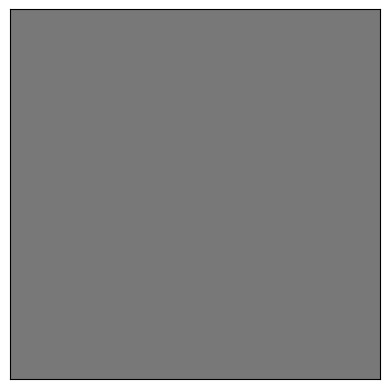

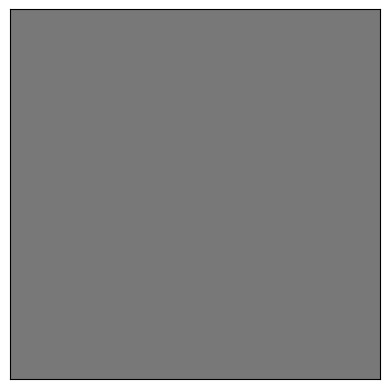

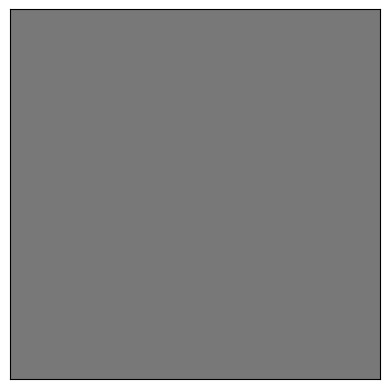

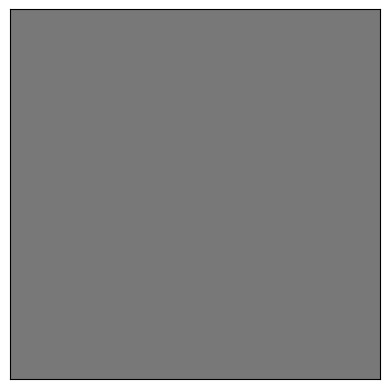

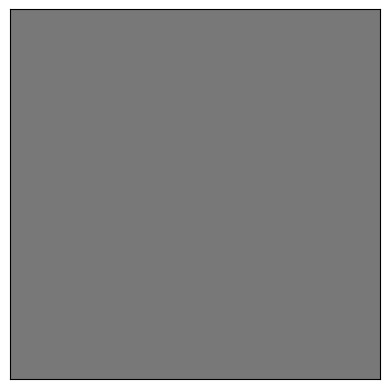

In [24]:
from semseg.datasets import *

#model = model.to(device)
predictions = []
start = time.time()
#print('test')
# Use torch.no_grad() to disable gradient computation during testing
with torch.no_grad():

    for images, labels in train_loader:
        # Move the data to the desired device
        print(images.shape)
        images = images.permute(0,3,1,2).to(device)
        #images = images.permute(2,0,1).to(device)
        #images = images [None, :, :, :]
        print(images.shape)
        
        #print(images.shape)
        #labels = labels.to(device)

        # Forward pass to get the predictions
        with torch.inference_mode():
          prediction = model(images)
        #print(prediction)
        prediction = prediction.softmax(1).argmax(1).to(int)
        #prediction = prediction.round().to(int)
        #print(prediction.shape)
        un = prediction.unique()
        #print(un)
        palette = eval('ADE20K').PALETTE.to(device)
        prediction_map = palette[prediction].squeeze().to(torch.uint8)
        #print(type(prediction_map))
        show_image(prediction_map)
        predictions.append(prediction_map)
        
end = time.time()
print(end-start)